In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left']
predictors = predictors.drop(['pitch_locx', 'pitch_locy', 'pitchHand_isRight', 'batSide_isRight'], axis=1)
predictors = predictors.join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

In [6]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=3)

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    calls, 
                                                    test_size = 0.25, 
                                                    stratify = calls,
                                                    random_state = 837)

In [8]:
# Create a StandardScaler object and fit_transform X_train data
scaler_calls = StandardScaler()

X_train_scaled = scaler_calls.fit_transform(X_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
# Transform X_test data
X_test_scaled = scaler_calls.transform(X_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [10]:
def fit_save_model(model, output_model_name, X_train, y_train):
    '''Function that takes an instantiated model, fits training data, and saves the best model.
    Also returns the training history of the model'''
    
    # Designate saved model name
    checkpoint_path = 'model_final/%s.hdf5' %(output_model_name)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only = True,
                                                     verbose=1)
    
    # fit the training data to the basic model
    training_history = model.fit(X_train,
                                 y_train,
                                 validation_split = 0.25,
                                 epochs = 25,
                                 callbacks = [early_stopping_monitor, cp_callback])
    
    return checkpoint_path, training_history

In [11]:
def train_hist_plot(training_history, figname):
    '''Function to plot training history statistics from a model'''
    _ = plt.figure(figsize=(15, 15))

    _ = plt.subplot(2, 1, 1)
    _ = plt.plot(training_history.history['categorical_accuracy'])
    _ = plt.plot(training_history.history['val_categorical_accuracy'])
    _ = plt.title('Model Accuracy')
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')

    _ = plt.subplot(2, 1, 2)
    _ = plt.plot(training_history.history['loss'])
    _ = plt.plot(training_history.history['val_loss'])
    _ = plt.title('Model Loss')
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')
    
    save_path = 'model_final/%s.png' %(figname)
    _ = plt.savefig(save_path)

In [12]:
def model_metrics(model, test_pred, test_labels, threshold = 0.2):
    '''This function will print the metrics and scores of a model on test data'''
    
    # Make predictions on the test data
    predictions = model.predict(test_pred)
    
    # Classify predictions based on threshold value
    predictions[predictions > threshold] = 1
    predictions[predictions < threshold] = 0
    
    predictions_df = pd.DataFrame(predictions,
                                  index = test_labels.index.values,
                                  columns = test_labels.columns.values)
    
    for i in test_labels.columns.values:
        # Create a confusion matrix
        accuracy = accuracy_score(np.array(test_labels[i]), np.array(predictions_df[i]))
        recall = recall_score(np.array(test_labels[i]), np.array(predictions_df[i]))
        precision = precision_score(np.array(test_labels[i]), np.array(predictions_df[i]))
        print(i)
        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precision:', precision)
        
    # Calculate AUC score
    auc = roc_auc_score(test_labels, predictions)
    print('AUC:', auc)
    
    # Make predictions on the test set
    score, acc = model.evaluate(test_pred, test_labels)
    print('Test score:', score)
    print('Test accuracy:', acc)

# model_calls_id

In "Machine_Learning_Models" notebook, we built a model that took pitch location, pitch type, pitch speed, count, inning, and player ID number to predict the probability of 6 outcomes: ball, called strike, swinging strike, foul ball, hit, and out. The model was a neural network with 3 hidden layers and 1 output layer. The goal of this notebook is to improve upon the results of that model by increasing the capacity and/or the activation functions. The metrics of that model were as follows:
+ Test Score: 0.3443
+ Test Accuracy: 0.5012
+ AUC: 0.7824

Like the other notebook, the models are going to start simple and increase until the gains/losses start diminishing.

## Base Model

In [13]:
# Instatiate a Sequential model
model_final_base = Sequential()

# Create a basic network
model_final_base.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final_base.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [14]:
base_checkpoint_path, base_history = fit_save_model(model_final_base, 'model_final_base', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3476 - categorical_accuracy: 0.4990 - val_loss: 0.3453 - val_categorical_accuracy: 0.5035

Epoch 00001: val_loss improved from inf to 0.34533, saving model to model_final/model_final_base.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3453 - categorical_accuracy: 0.5009 - val_loss: 0.3451 - val_categorical_accuracy: 0.4992

Epoch 00002: val_loss improved from 0.34533 to 0.34514, saving model to model_final/model_final_base.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3450 - categorical_accuracy: 0.5008 - val_loss: 0.3449 - val_categorical_accuracy: 0.5060

Epoch 00003: val_loss improved from 0.34514 to 0.34493, saving model to model_final/model_final_base.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3449 - categoric

In [15]:
# Load best model to save training time
model_final_base = keras.models.load_model('model_final/model_final_base.hdf5')

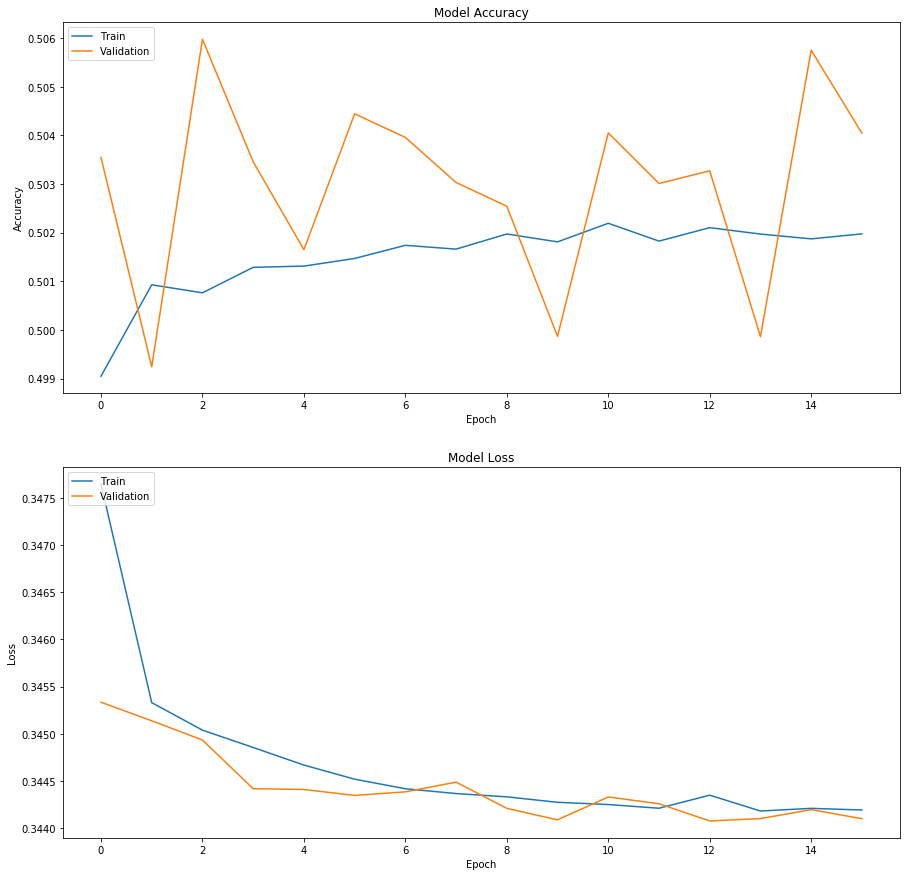

In [16]:
train_hist_plot(base_history, "model_final_base_train_perf")

In [17]:
model_metrics(model_final_base, X_test_scaled, y_test, threshold = 0.3)

call_B
Accuracy: 0.8090151046959618
Recall: 0.8374381924015772
Precision: 0.6948684546505035
call_C
Accuracy: 0.8105197510664957
Recall: 0.6524493620058892
Precision: 0.45626569739325773
call_F
Accuracy: 0.7863552430633173
Recall: 0.311257061994318
Precision: 0.36571094949802635
call_H
Accuracy: 0.9358167825363342
Recall: 5.855658029571073e-05
Precision: 0.11764705882352941
call_S
Accuracy: 0.880424757349944
Recall: 0.04289509067654872
Precision: 0.3310554290053151
is_out
Accuracy: 0.7965947279144775
Recall: 0.4832745526537854
Precision: 0.42466560827447214
AUC: 0.6417058205493464
532351/532351 [==============================] - 4s 8us/step
Test score: 0.34438113663181164
Test accuracy: 0.5024542078431771


## Model 2

In [18]:
# Instatiate a Sequential model
model_final2 = Sequential()

# Create a basic network
model_final2.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final2.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [19]:
final2_checkpoint_path, final2_history = fit_save_model(model_final2, 'model_final2', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3496 - categorical_accuracy: 0.4985 - val_loss: 0.3455 - val_categorical_accuracy: 0.5008

Epoch 00001: val_loss improved from inf to 0.34550, saving model to model_final/model_final2.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3455 - categorical_accuracy: 0.5003 - val_loss: 0.3453 - val_categorical_accuracy: 0.5050

Epoch 00002: val_loss improved from 0.34550 to 0.34525, saving model to model_final/model_final2.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3451 - categorical_accuracy: 0.5007 - val_loss: 0.3451 - val_categorical_accuracy: 0.4959

Epoch 00003: val_loss improved from 0.34525 to 0.34515, saving model to model_final/model_final2.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3448 - categorical_accuracy:

In [20]:
# Load best model to save training time
model_final2 = keras.models.load_model('model_final/model_final2.hdf5')

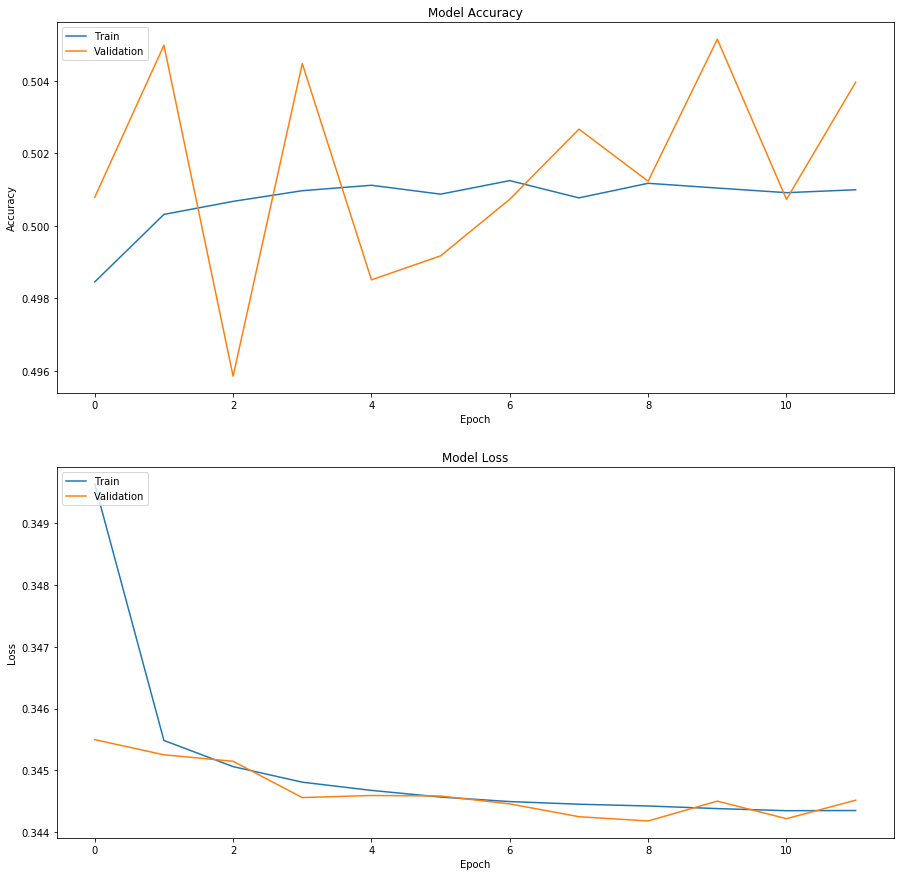

In [21]:
train_hist_plot(final2_history, "model_final2_train_perf")

In [22]:
model_metrics(model_final2, X_test_scaled, y_test, threshold = 0.3)

call_B
Accuracy: 0.8110400844555565
Recall: 0.8320658863783356
Precision: 0.6999161997692203
call_C
Accuracy: 0.8055850369399137
Recall: 0.672726867136611
Precision: 0.448534606489228
call_F
Accuracy: 0.7766266993017764
Recall: 0.35536279476737276
Precision: 0.35705602709097617
call_H
Accuracy: 0.9358393240549938
Recall: 2.9278290147855364e-05
Precision: 0.3333333333333333
call_S
Accuracy: 0.876156896483711
Recall: 0.07137703735283507
Precision: 0.3189478311840563
is_out
Accuracy: 0.7942560453535356
Recall: 0.4950126576800744
Precision: 0.42130269045909063
AUC: 0.6467486078810311
532351/532351 [==============================] - 5s 9us/step
Test score: 0.3444133637452494
Test accuracy: 0.5001850282981025


## Model 3

In [23]:
# Instatiate a Sequential model
model_final3 = Sequential()

# Create a basic network
model_final3.add(Dense(50, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final3.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [24]:
final3_checkpoint_path, final3_history = fit_save_model(model_final3, 'model_final3', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3496 - categorical_accuracy: 0.4974 - val_loss: 0.3465 - val_categorical_accuracy: 0.4997

Epoch 00001: val_loss improved from inf to 0.34647, saving model to model_final/model_final3.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3463 - categorical_accuracy: 0.5000 - val_loss: 0.3461 - val_categorical_accuracy: 0.5049

Epoch 00002: val_loss improved from 0.34647 to 0.34612, saving model to model_final/model_final3.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3458 - categorical_accuracy: 0.5006 - val_loss: 0.3456 - val_categorical_accuracy: 0.4999

Epoch 00003: val_loss improved from 0.34612 to 0.34557, saving model to model_final/model_final3.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3456 - categorical_accuracy:

In [25]:
# Load best model to save training time
model_final3 = keras.models.load_model('model_final/model_final3.hdf5')

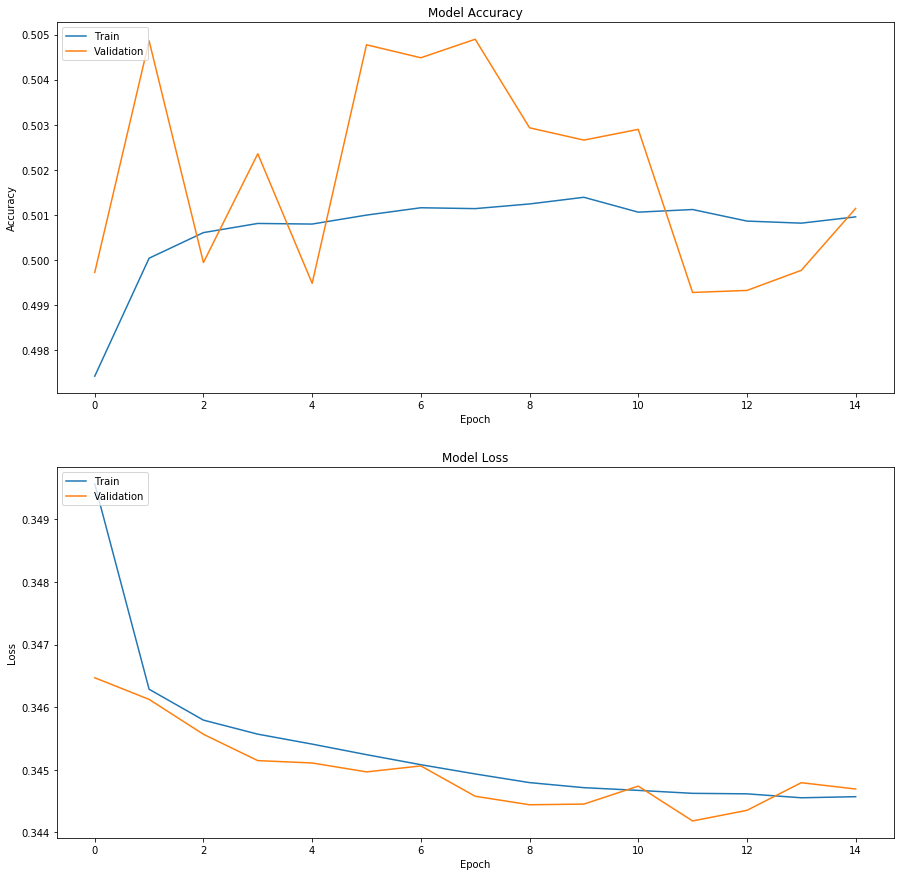

In [26]:
train_hist_plot(final3_history, "model_final3_train_perf")

In [27]:
model_metrics(model_final3, X_test_scaled, y_test)

call_B
Accuracy: 0.7803516852602888
Recall: 0.8758945150320252
Precision: 0.6432473014486758
call_C
Accuracy: 0.7579698356911135
Recall: 0.816409386990274
Precision: 0.3944153765741105
call_F
Accuracy: 0.6651288341714395
Recall: 0.6743218865111857
Precision: 0.29648909491602704
call_H
Accuracy: 0.9214183874924626
Recall: 0.07135119309032352
Precision: 0.1941523263224984
call_S
Accuracy: 0.7975320793987426
Recall: 0.3593775620634244
Precision: 0.2418240797952158
is_out
Accuracy: 0.7219071627554001
Recall: 0.6764718610035269
Precision: 0.34610083745232945
AUC: 0.681258440001915
532351/532351 [==============================] - 5s 9us/step
Test score: 0.3444444792877255
Test accuracy: 0.49815441316052234


## Model 4

In [31]:
# Instatiate a Sequential model
model_final4 = Sequential()

# Create a basic network
model_final4.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final4.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [32]:
final4_checkpoint_path, final4_history = fit_save_model(model_final4, 'model_final4', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 44s 36us/step - loss: 0.3488 - categorical_accuracy: 0.4982 - val_loss: 0.3461 - val_categorical_accuracy: 0.4984

Epoch 00001: val_loss improved from inf to 0.34612, saving model to model_final/model_final4.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3459 - categorical_accuracy: 0.5007 - val_loss: 0.3459 - val_categorical_accuracy: 0.5004

Epoch 00002: val_loss improved from 0.34612 to 0.34591, saving model to model_final/model_final4.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3455 - categorical_accuracy: 0.5008 - val_loss: 0.3454 - val_categorical_accuracy: 0.5027

Epoch 00003: val_loss improved from 0.34591 to 0.34540, saving model to model_final/model_final4.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3453 - categorical_accuracy:

In [33]:
# Load best model to save training time
model_final4 = keras.models.load_model('model_final/model_final4.hdf5')

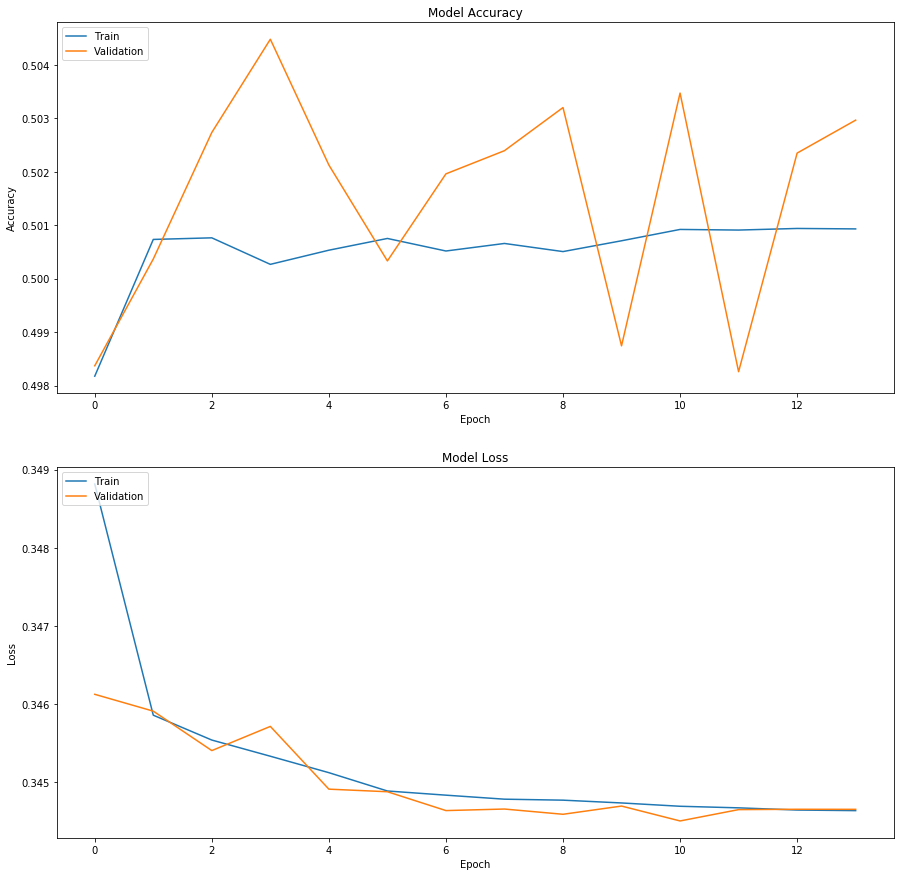

In [34]:
train_hist_plot(final4_history, "model_final4_train_perf")

In [35]:
model_metrics(model_final4, X_test_scaled, y_test)

call_B
Accuracy: 0.7673039028761099
Recall: 0.8892574742859527
Precision: 0.6242018628082714
call_C
Accuracy: 0.7622358180974582
Recall: 0.8040064245560811
Precision: 0.3980650077863557
call_F
Accuracy: 0.670281449645065
Recall: 0.6655288258995603
Precision: 0.2988267134881871
call_H
Accuracy: 0.9297305724982201
Recall: 0.03413848631239936
Precision: 0.20877350044762757
call_S
Accuracy: 0.8113838426151168
Recall: 0.3197127209523497
Precision: 0.24863555215506247
is_out
Accuracy: 0.72498032313267
Recall: 0.6663998095938723
Precision: 0.34767933442080723
AUC: 0.6755149719121399
532351/532351 [==============================] - 9s 17us/step
Test score: 0.3446575868357825
Test accuracy: 0.5026965291704482


## Model 5

In [36]:
# Instatiate a Sequential model
model_final5 = Sequential()

# Create a basic network
model_final5.add(Dense(24, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final5.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [37]:
final5_checkpoint_path, final5_history = fit_save_model(model_final5, 'model_final5', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 44s 36us/step - loss: 0.3505 - categorical_accuracy: 0.4962 - val_loss: 0.3472 - val_categorical_accuracy: 0.5014

Epoch 00001: val_loss improved from inf to 0.34717, saving model to model_final/model_final5.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3470 - categorical_accuracy: 0.4998 - val_loss: 0.3463 - val_categorical_accuracy: 0.5041

Epoch 00002: val_loss improved from 0.34717 to 0.34634, saving model to model_final/model_final5.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 29s 25us/step - loss: 0.3462 - categorical_accuracy: 0.5000 - val_loss: 0.3458 - val_categorical_accuracy: 0.5021

Epoch 00003: val_loss improved from 0.34634 to 0.34582, saving model to model_final/model_final5.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3457 - categorical_accuracy:

In [38]:
# Load best model to save training time
model_final5 = keras.models.load_model('model_final/model_final5.hdf5')

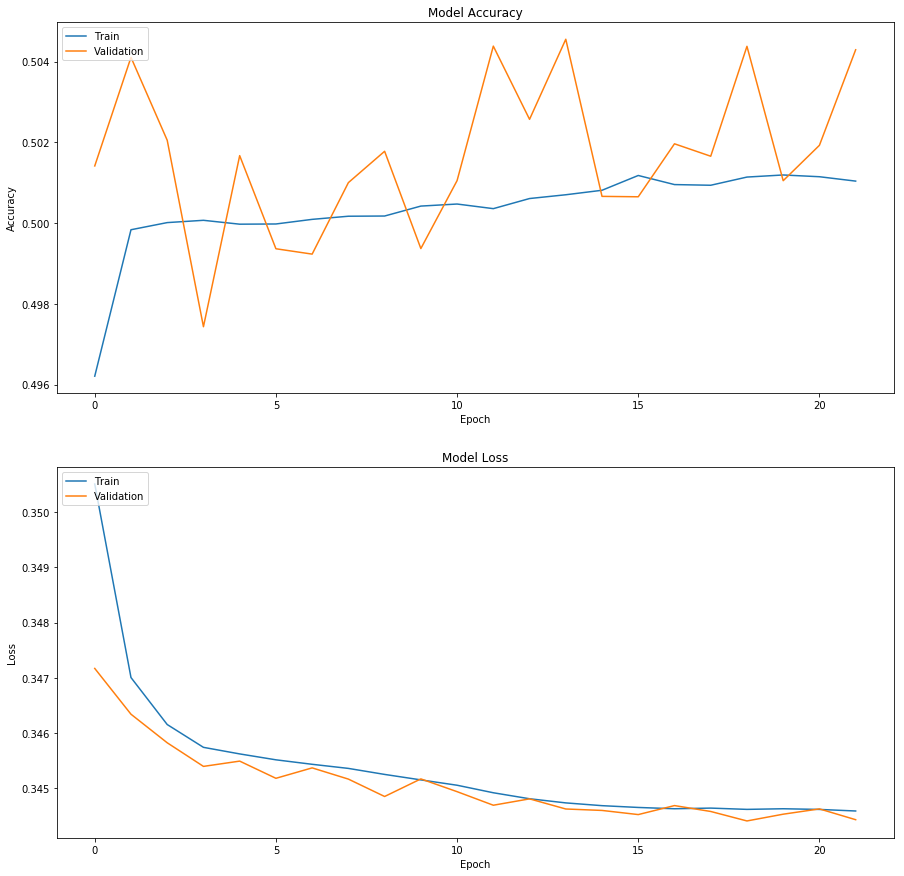

In [39]:
train_hist_plot(final5_history, "model_final5_train_perf")

In [40]:
model_metrics(model_final5, X_test_scaled, y_test)

call_B
Accuracy: 0.7632295233783726
Recall: 0.892533016210803
Precision: 0.6187423389414993
call_C
Accuracy: 0.7650798063683547
Recall: 0.7987641652538592
Precision: 0.40090241390120473
call_F
Accuracy: 0.6660173456986086
Recall: 0.6729283916476726
Precision: 0.2969072459761788
call_H
Accuracy: 0.9238115453901655
Recall: 0.058702971746450006
Precision: 0.19252928749759937
call_S
Accuracy: 0.80655432224228
Recall: 0.3327812940674909
Precision: 0.24574680632076043
is_out
Accuracy: 0.7433760808188582
Recall: 0.6302334638769284
Precision: 0.3625303379177298
AUC: 0.6764446928266342
532351/532351 [==============================] - 10s 19us/step
Test score: 0.3445531608504485
Test accuracy: 0.5032694594363817


## Model 6

In [41]:
# Instatiate a Sequential model
model_final6 = Sequential()

# Create a basic network
model_final6.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final6.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final6.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [42]:
final6_checkpoint_path, final6_history = fit_save_model(model_final6, 'model_final6', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 46s 39us/step - loss: 0.3509 - categorical_accuracy: 0.4975 - val_loss: 0.3466 - val_categorical_accuracy: 0.5018

Epoch 00001: val_loss improved from inf to 0.34663, saving model to model_final/model_final6.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3460 - categorical_accuracy: 0.5006 - val_loss: 0.3456 - val_categorical_accuracy: 0.4986

Epoch 00002: val_loss improved from 0.34663 to 0.34556, saving model to model_final/model_final6.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3454 - categorical_accuracy: 0.5010 - val_loss: 0.3452 - val_categorical_accuracy: 0.5023

Epoch 00003: val_loss improved from 0.34556 to 0.34517, saving model to model_final/model_final6.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3451 - categorical_accuracy:

In [43]:
# Load best model to save training time
model_final6 = keras.models.load_model('model_final/model_final6.hdf5')

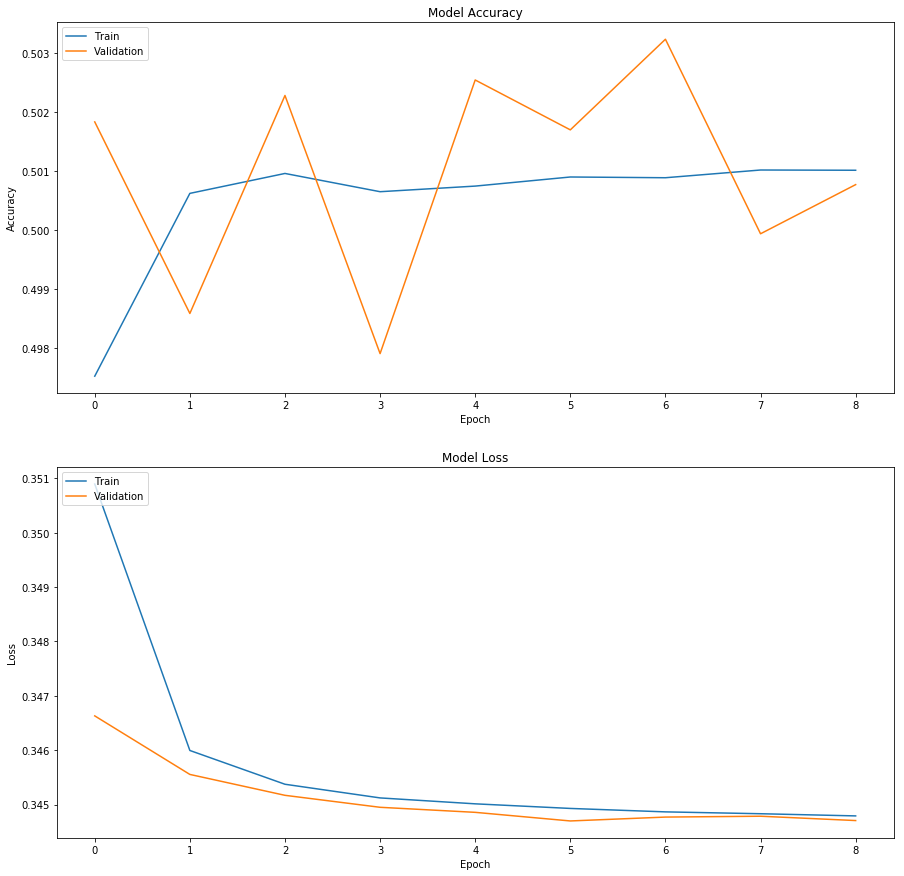

In [44]:
train_hist_plot(final6_history, "model_final6_train_perf")

In [45]:
model_metrics(model_final6, X_test_scaled, y_test)

call_B
Accuracy: 0.7593392329496892
Recall: 0.895636435709666
Precision: 0.613657968279835
call_C
Accuracy: 0.7620573644080691
Recall: 0.804932185241367
Precision: 0.39794978687268057
call_F
Accuracy: 0.6619617507997543
Recall: 0.6812569539714604
Precision: 0.295371732064408
call_H
Accuracy: 0.9332207509706941
Recall: 0.014697701654223393
Precision: 0.20925385577323885
call_S
Accuracy: 0.8064885761461893
Recall: 0.3329124717148198
Precision: 0.24569195023960502
is_out
Accuracy: 0.7380825808536098
Recall: 0.6391912066988338
Precision: 0.3577232326657141
AUC: 0.6737782546983017
532351/532351 [==============================] - 10s 18us/step
Test score: 0.34487756825310123
Test accuracy: 0.5005813833345353


## Model 7

In [ ]:
# Instatiate a Sequential model
model_final7 = Sequential()

# Create a basic network
model_final7.add(Dense(25, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final7.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final7.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
final7_checkpoint_path, final7_history = fit_save_model(model_final7, 'model_final7', X_train_scaled, y_train)

In [ ]:
# Load best model to save training time
model_final7 = keras.models.load_model('model_final/model_final7.hdf5')

In [ ]:
train_hist_plot(final7_history, "model_final7_train_perf")

In [ ]:
model_metrics(model_final7, X_test_scaled, y_test)

## Model 8

In [ ]:
# Instatiate a Sequential model
model_final8 = Sequential()

# Create a basic network
model_final8.add(Dense(10, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final8.add(Dense(10, activation = 'elu'))
model_final8.add(Dense(5, activation= 'elu'))
model_final8.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final8.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
final8_checkpoint_path, final8_history = fit_save_model(model_final8, 'model_final8', X_train_scaled, y_train)

In [ ]:
# Load best model to save training time
model_final8 = keras.models.load_model('model_final/model_final8.hdf5')

In [ ]:
train_hist_plot(final8_history, "model_final8_train_perf")

In [ ]:
model_metrics(model_final8, X_test_scaled, y_test)

## Model 9

In [ ]:
# Instatiate a Sequential model
model_final9 = Sequential()

# Create a basic network
model_final9.add(Dense(10, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final9.add(Dense(10, activation = 'relu'))
model_final9.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final9.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
final9_checkpoint_path, final9_history = fit_save_model(model_final9, 'model_final9', X_train_scaled, y_train)

In [ ]:
# Load best model to save training time
model_final9 = keras.models.load_model('model_final/model_final9.hdf5')

In [ ]:
train_hist_plot(final9_history, "model_final9_train_perf")

In [ ]:
model_metrics(model_final9, X_test_scaled, y_test)

## Model 10

In [ ]:
# Instatiate a Sequential model
model_finalX = Sequential()

# Create a basic network
model_finalX.add(Dense(10, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_finalX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
finalX_checkpoint_path, finalX_history = fit_save_model(model_finalX, 'model_finalX', X_train_scaled, y_train)

In [ ]:
# Load best model to save training time
model_finalX = keras.models.load_model('model_final/model_finalX.hdf5')

In [ ]:
train_hist_plot(finalX_history, "model_finalX_train_perf")

In [ ]:
model_metrics(model_finalX, X_test_scaled, y_test)